In [1]:
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
import geopandas

pd.set_option('display.max_columns', None)

import csv
from datetime import datetime, timedelta
import json

## Query sampled data

### Generate datetimes and querys

In [307]:
# Get the 8-15th of each month in 2019; each day 4 timings

year = [2019]
month = list(range(1,13))
day = list(range(8,15))
hour = [8, 12, 18, 00]

In [308]:
query_list = []
for y in year:
    for m in month:
        for d in day:
            for h in hour:
                query_list.append("{}-{:0>2d}-{:0>2d}T{:0>2d}:00:00".format(y, m, d, h))

In [309]:
len(query_list)

336

### Get Weather Data

In [6]:
def get_weather_data(query:str):
    '''Returns dictionary of JSON objects for weather data given a datetime string
    Each entry in the dictionary is the JSON response for each of the API Endpoints of
     ["air-temperature","rainfall","relative-humidity"]    
    '''
    data_sets = ["air-temperature","rainfall","relative-humidity"]
    results={}
    for measure in data_sets:
        URL = "https://api.data.gov.sg/v1/environment/"+measure
        params={'date_time':query}
        r=requests.get(URL,params=params)
        results[measure]=r.json()
    return results

In [7]:
# query data from API
weather = {}
for query in query_list:
    weather[query] = get_weather_data(query)

In [112]:
# save weather data in json file
# with open("weather_data_2019.json", "w") as outfile:
#     json.dump(weather, outfile)
    
# to open:
with open('weather_data_2019.json', 'r') as openfile:
    weather = json.load(openfile)

In [113]:
temp = {}
temp_loc = {}
rain = {}
rain_loc = {}
humid = {}
humid_loc = {}

for i in weather.keys():
    temp[i] = weather[i]['air-temperature']['items'][0]['readings']
    rain[i] = weather[i]['rainfall']['items'][0]['readings']
    humid[i] = weather[i]['relative-humidity']['items'][0]['readings']
    
    for d in weather[i]['air-temperature']['metadata']['stations']:
        if d['id'] not in temp_loc.keys():
            temp_loc[d['id']] = {'name': d['name'], 'location': d['location']}
    for d in weather[i]['rainfall']['metadata']['stations']:
        if d['id'] not in rain_loc.keys():
            rain_loc[d['id']] = {'name': d['name'], 'location': d['location']}
    for d in weather[i]['relative-humidity']['metadata']['stations']:
        if d['id'] not in humid_loc.keys():
            humid_loc[d['id']] = {'name': d['name'], 'location': d['location']}

In [75]:
print(len(temp_loc.keys()), 'stations providing readings for temperature')
print(len(rain_loc.keys()), 'stations providing readings for rain')
print(len(humid_loc.keys()), 'stations providing readings for humidity')

17 stations providing readings for temperature
54 stations providing readings for rain
17 stations providing readings for humidity


In [64]:
# check if name & location of station ids are same for rain and temp
for i in rain_loc.keys():
    if i in temp_loc.keys():
        if rain_loc[i]['name'] == temp_loc[i]['name'] and rain_loc[i]['location'] == temp_loc[i]['location']:
            continue
        else:
            print('rain:', i, rain_loc[i], 'temp:', temp_loc[i])

In [70]:
# check if name & location of station ids are same for rain and humid
for i in rain_loc.keys():
    if i in humid_loc.keys():
        if rain_loc[i]['name'] == humid_loc[i]['name'] and rain_loc[i]['location'] == humid_loc[i]['location']:
            continue
        else:
            print('rain:', i, rain_loc[i], 'temp:', humid_loc[i])

In [58]:
# explore temperature
tempdf = pd.DataFrame(columns=list(temp_loc.keys()))
tempdf['datetime'] = temp.keys()
tempdf = tempdf.set_index('datetime')
for k, v in temp.items():
    for x in v:
        tempdf.loc[k, x['station_id']] = x['value']

In [83]:
tempdf

,S109,S117,S107,S43,S108,S44,S111,S122,S115,S24,S116,S104,S100,S50,S121,S106,S60
datetime,,,,,,,,,,,,,,,,,
2019-01-08T08:00:00,26.3,27.4,27.9,27.3,27.5,25.8,26.9,26.8,27,27.3,27.2,26.1,26.9,NaN,NaN,NaN,NaN
2019-01-08T12:00:00,27.5,31.6,30,27.1,29.3,30.5,29,29.8,31.6,30.6,30.3,30,30.8,29.5,30.6,28.1,30.5
2019-01-08T18:00:00,28.8,27.1,29.5,29.5,29.3,24.9,28.4,29.3,25.8,29.5,26.9,26.6,26.8,26.1,25.2,29.6,29.1
2019-01-08T00:00:00,27,28.1,28.4,27.7,28,26.8,27.3,27.4,27.9,27.7,27.9,26.8,27.6,27,27.4,26.8,28.1
2019-01-09T08:00:00,NaN,27.2,27.5,27.2,27.1,26,NaN,26.6,26.5,27.4,26.8,25.9,26.5,26.2,NaN,26.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-13T00:00:00,25.8,26.9,26.8,27,27.1,24.9,25.9,26,26.3,26.2,26.7,25.8,26.5,26,25.7,25.8,26.8
2019-12-14T08:00:00,23.2,23.7,23.8,23.8,23.8,22.9,22.8,23.1,23.7,23.5,23.7,23,23.5,23,23.2,23.3,23.7
2019-12-14T12:00:00,24.1,24.3,24.8,24.4,24.5,23.6,23.4,24.8,24.2,24.6,24.1,24.2,24.3,23.4,24.2,25.2,24.4


In [93]:
tempdf.astype('float').describe()

,S109,S117,S107,S43,S108,S44,S111,S122,S115,S24,S116,S104,S100,S50,S121,S106,S60
count,232.000000,302.000000,305.000000,319.000000,227.000000,297.000000,309.00000,290.000000,287.000000,290.000000,299.000000,317.000000,301.000000,307.000000,242.000000,295.000000,261.00000
mean,28.396552,28.972517,28.451803,29.010031,29.415859,28.028956,28.28479,28.202414,28.756794,28.797241,28.818060,28.300631,28.775083,28.360261,28.714876,28.132881,29.16590
std,2.276891,1.835712,1.572357,2.039814,2.028997,2.140891,1.98468,2.544720,1.922488,2.056854,1.747676,2.288856,2.481225,2.204211,2.465081,2.480585,1.75789
min,23.100000,23.700000,22.400000,23.300000,23.800000,22.900000,22.80000,23.100000,23.700000,22.800000,23.700000,23.000000,23.500000,23.000000,23.000000,22.900000,23.70000
25%,27.000000,27.900000,27.700000,27.600000,28.100000,26.400000,27.10000,26.400000,27.500000,27.400000,27.800000,26.600000,27.000000,26.900000,27.000000,26.200000,27.90000
50%,28.100000,28.700000,28.600000,28.800000,29.200000,28.000000,28.00000,27.550000,28.500000,28.750000,28.800000,28.000000,28.300000,28.000000,28.500000,27.600000,29.20000
75%,30.500000,30.600000,29.500000,30.700000,31.000000,30.000000,29.90000,30.575000,30.350000,30.575000,30.300000,30.300000,30.900000,30.200000,30.875000,30.300000,30.60000
max,32.700000,33.400000,33.400000,33.000000,33.300000,32.600000,33.50000,33.100000,33.400000,32.600000,32.000000,33.400000,34.000000,33.900000,33.300000,33.000000,33.00000


<AxesSubplot:>

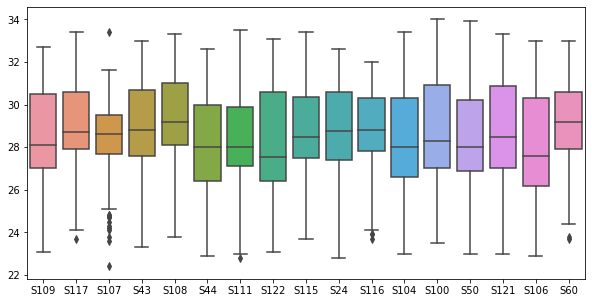

In [108]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=tempdf)

In [193]:
temp_cols = tempdf.columns.tolist()
tempdf['mean'] = tempdf.loc[:,temp_cols].mean(axis=1)

In [194]:
tempdf1 = tempdf.reset_index()
tempdf1[['date', 'time']] = tempdf1['datetime'].str.split('T', 1, expand=True)
tempdf1['date'] = pd.to_datetime(tempdf1['date'], format='%Y-%m-%d')
tempdf1['time'] = pd.to_datetime(tempdf1['time'], format='%H:%M:%S').dt.time

C:\Users\User\AppData\Local\Temp/ipykernel_24620/709808342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_mon_time['month'] = temp_mon_time['date'].apply(lambda x: x.strftime('%b'))


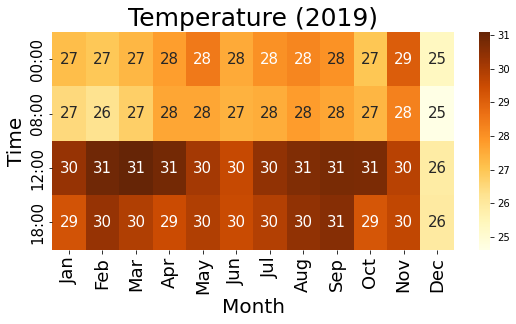

In [230]:
temp_mon_time = tempdf1[['mean', 'date', 'time']]
temp_mon_time['month'] = temp_mon_time['date'].apply(lambda x: x.strftime('%b'))
temp_pv = temp_mon_time.pivot_table(index='time', columns='month', values='mean', aggfunc='mean')
temp_pv = temp_pv[["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]]

plt.figure(figsize=(9,4))
sns.heatmap(temp_pv, annot=True, fmt='.0f', cmap='YlOrBr', annot_kws={"size":15}, 
            yticklabels=['00:00', '08:00', '12:00', '18:00'])
plt.title('Temperature (2019)', fontsize=25)
plt.xlabel('Month', fontsize=20)
plt.xticks(fontsize=18, rotation=90)
plt.ylabel('Time', fontsize=20)
plt.yticks(fontsize=15)
plt.show()

In [109]:
# explore humidity
humiddf = pd.DataFrame(columns=list(humid_loc.keys()))
humiddf['datetime'] = humid.keys()
humiddf = humiddf.set_index('datetime')
for k, v in humid.items():
    for x in v:
        humiddf.loc[k, x['station_id']] = x['value']

In [110]:
humiddf

,S117,S107,S43,S108,S111,S115,S24,S116,S104,S100,S109,S50,S121,S106,S122,S60,S44
datetime,,,,,,,,,,,,,,,,,
2019-01-08T08:00:00,87.2,86.5,89.7,89.2,82.8,86,85.7,93.8,90.5,85.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08T12:00:00,62.1,74.8,92.6,72.9,69.6,60.1,72,76.3,69.7,64.7,96.5,70.7,66.5,89.4,73.8,69.8,NaN
2019-01-08T18:00:00,90.7,74.4,74.7,75.9,71.7,90.4,72.3,95.9,82.6,87.2,75.5,95.7,97.3,74.8,75.7,73.7,NaN
2019-01-08T00:00:00,81.4,83.8,84.6,82.2,78.7,79.8,83.8,88.7,85.8,81.3,92.3,84.8,83.2,88.5,NaN,75.4,NaN
2019-01-09T08:00:00,87.9,88.3,89.6,91.2,NaN,86.1,86.2,95.6,90.1,87.1,NaN,90.5,NaN,91,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-13T00:00:00,76.5,77.6,77.5,73.9,75,78,80.2,84.1,77.5,74.8,82,79.2,81.1,82.7,81.5,70.8,83.5
2019-12-14T08:00:00,NaN,98.7,NaN,NaN,98.5,93.9,99,NaN,97.7,95.6,NaN,99.3,99.4,99.1,NaN,93.6,99.2
2019-12-14T12:00:00,100,95.8,NaN,NaN,99.2,93.8,96.1,NaN,92.3,94.7,NaN,99.3,99.4,93.8,NaN,92.9,98.6


In [111]:
humiddf.astype('float').describe()

,S117,S107,S43,S108,S111,S115,S24,S116,S104,S100,S109,S50,S121,S106,S122,S60,S44
count,300.000000,305.000000,309.000000,219.000000,309.000000,287.000000,284.000000,291.000000,317.000000,301.000000,196.000000,307.000000,242.000000,295.000000,151.000000,261.000000,125.000000
mean,77.473667,79.708525,76.224919,73.237900,72.999029,75.256446,78.325000,82.240206,74.911672,74.544850,75.111224,76.634528,75.055785,80.678644,70.975497,71.156322,76.484800
std,11.037204,7.863866,11.692774,11.271266,10.846385,9.552458,11.079343,9.752856,11.861581,12.637896,13.195290,12.074436,12.978213,12.525272,12.828915,9.294341,15.747658
min,44.600000,57.300000,41.300000,44.400000,41.300000,43.000000,50.500000,49.400000,43.000000,42.000000,40.100000,45.400000,43.800000,52.600000,47.500000,42.300000,30.700000
25%,69.050000,74.900000,66.200000,63.850000,64.300000,68.150000,68.675000,75.500000,64.100000,63.100000,63.500000,66.600000,64.300000,68.550000,62.000000,64.500000,66.600000
50%,79.650000,80.500000,79.000000,75.000000,74.700000,76.700000,80.550000,84.100000,77.800000,76.700000,76.350000,79.200000,75.700000,83.000000,67.300000,72.100000,81.100000
75%,85.525000,84.800000,85.400000,82.300000,81.200000,82.400000,85.925000,89.650000,84.300000,85.000000,85.000000,85.750000,85.475000,92.100000,79.900000,77.700000,88.600000
max,100.000000,98.700000,99.700000,97.100000,99.200000,93.900000,99.800000,99.600000,97.700000,95.600000,99.000000,99.300000,99.400000,99.100000,100.000000,93.600000,99.200000


<AxesSubplot:>

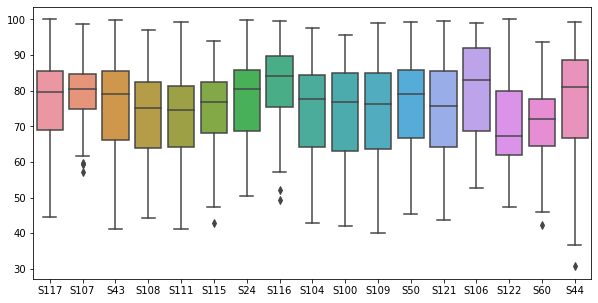

In [112]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=humiddf)

In [181]:
humid_cols = humiddf.columns.tolist()
humiddf['mean'] = humiddf.loc[:,humid_cols].mean(axis=1)

In [183]:
humiddf1 = humiddf.reset_index()
humiddf1[['date', 'time']] = humiddf1['datetime'].str.split('T', 1, expand=True)
humiddf1['date'] = pd.to_datetime(humiddf1['date'], format='%Y-%m-%d')
humiddf1['time'] = pd.to_datetime(humiddf1['time'], format='%H:%M:%S').dt.time

In [ ]:
rain_byMonth = raindf1.set_index('date')
rain_byMonth = rain_byMonth.groupby(pd.Grouper(freq='M'))['total'].sum()

C:\Users\User\AppData\Local\Temp/ipykernel_24620/524718372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  humid_mon_time['month'] = humid_mon_time['date'].apply(lambda x: x.strftime('%b'))


<AxesSubplot:xlabel='month', ylabel='time'>

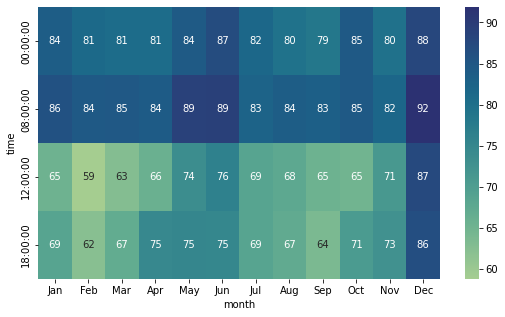

In [206]:
humid_mon_time = humiddf1[['mean', 'date', 'time']]
humid_mon_time['month'] = humid_mon_time['date'].apply(lambda x: x.strftime('%b'))
humid_pv = humid_mon_time.pivot_table(index='time', columns='month', values='mean', aggfunc='mean')
humid_pv = humid_pv[["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]]

plt.figure(figsize=(9,5))
sns.heatmap(humid_pv, annot=True, fmt='.0f', cmap='crest')

In [114]:
# explore rainfall
raindf = pd.DataFrame(columns=list(rain_loc.keys()))
raindf['datetime'] = rain.keys()
raindf = raindf.set_index('datetime')
for k, v in rain.items():
    for x in v:
        raindf.loc[k, x['station_id']] = x['value']

In [114]:
raindf

,S105,S77,S109,S117,S55,S64,S90,S61,S114,S11,...,S82,S24,S69,S08,S116,S104,S100,S91,S84,S36
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-08T08:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
2019-01-08T12:00:00,0,0,0,0,1.4,0,0,0.2,0,NaN,...,0,0,0,0.2,0,0,0,0,NaN,NaN
2019-01-08T18:00:00,0,0,0,0,0,0,0,0,0,0.8,...,0,0,0,0,0,0,0,0,NaN,NaN
2019-01-08T00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
2019-01-09T08:00:00,0,0,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-13T00:00:00,0,0,0,0,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2019-12-14T08:00:00,0.2,0,0.2,0.4,NaN,0.4,0.4,0.4,0.6,0.6,...,0.2,0.4,0.2,0.4,0.2,0.4,0.4,0.2,0,NaN
2019-12-14T12:00:00,0,0,0,0,NaN,0,0,0,0,0,...,0.2,0.2,0,0,0,0,0,0,0,NaN


In [139]:
raindf.astype('float').describe()

,S105,S77,S109,S117,S55,S64,S90,S61,S114,S11,S50,S107,S215,S118,S120,S33,S71,S43,S66,S112,S07,S40,S108,S113,S44,S119,S121,S35,S29,S94,S78,S106,S81,S111,S900,S122,S60,S46,S79,S92,S88,S123,S89,S115,S82,S24,S69,S08,S116,S104,S100,S91,S84,S36
count,319.000000,319.000000,239.000000,316.000000,56.000000,319.000000,319.000000,319.000000,292.000000,284.000000,311.000000,310.000000,319.000000,304.000000,319.000000,315.000000,191.000000,319.000000,314.000000,278.000000,293.000000,306.000000,245.00000,319.000000,307.000000,315.000000,294.000000,316.000000,319.000000,318.000000,315.000000,306.000000,319.000000,317.000000,312.000000,292.000000,287.000000,263.000000,318.000000,310.000000,319.000000,319.000000,319.000000,289.000000,317.000000,315.000000,240.000000,319.000000,300.000000,319.000000,308.000000,176.000000,250.000000,123.0
mean,0.040752,0.001881,0.006695,0.006329,0.025000,0.025078,0.003762,0.005643,0.007534,0.025352,0.007074,0.012903,0.014636,0.007237,0.003762,0.024127,0.005236,0.010031,0.023567,0.018705,0.006826,0.015033,0.01551,0.005016,0.030619,0.020952,0.029252,0.037342,0.006897,0.005660,0.014603,0.009804,0.006897,0.006309,0.007051,0.007534,0.003484,0.013688,0.009434,0.002581,0.007524,0.011285,0.015674,0.003460,0.026498,0.015873,0.004167,0.012539,0.009333,0.047649,0.018182,0.007955,0.020800,0.0
std,0.431139,0.019334,0.048041,0.063430,0.187083,0.241844,0.031498,0.043068,0.072828,0.167896,0.056352,0.121857,0.163918,0.067586,0.031498,0.223298,0.038028,0.078666,0.186661,0.197299,0.056929,0.164076,0.12514,0.044580,0.322126,0.240896,0.322683,0.373058,0.053342,0.051163,0.173139,0.077894,0.053342,0.041620,0.040276,0.041593,0.031094,0.135786,0.126238,0.022608,0.056689,0.127375,0.162156,0.030987,0.244026,0.160816,0.033972,0.129219,0.117582,0.518330,0.152056,0.039196,0.304002,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,7.000000,0.200000,0.600000,1.000000,1.400000,2.800000,0.400000,0.400000,1.000000,2.000000,0.800000,2.000000,2.639000,1.000000,0.400000,3.200000,0.400000,1.000000,2.800000,3.200000,0.800000,2.800000,1.80000,0.600000,5.400000,4.200000,5.400000,5.400000,0.600000

In [140]:
rain_loc['S36']
# S36 has rather adnormal readings (either missing or 0)
# could be due to sampling of datetime

{'name': 'Upper Serangoon Road',
 'location': {'latitude': 1.3382, 'longitude': 103.8657}}

In [115]:
rain_cols = raindf.columns.tolist()
raindf['total'] = raindf.loc[:,rain_cols].sum(axis=1)

In [116]:
raindf1 = raindf.reset_index()

In [117]:
raindf1[['date', 'time']] = raindf1['datetime'].str.split('T', 1, expand=True)
raindf1['date'] = pd.to_datetime(raindf1['date'], format='%Y-%m-%d')
raindf1['time'] = pd.to_datetime(raindf1['time'], format='%H:%M:%S').dt.time

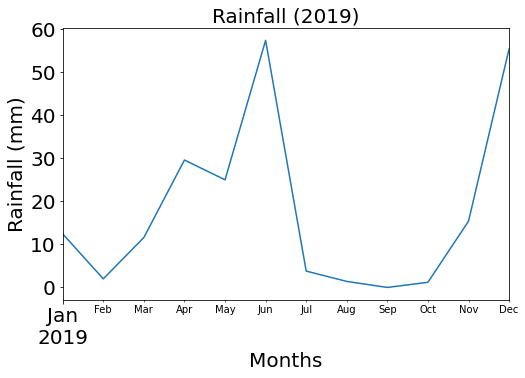

In [121]:
rain_byMonth = raindf1.set_index('date')
rain_byMonth = rain_byMonth.groupby(pd.Grouper(freq='M'))['total'].sum()

plt.figure(figsize=(8,5))
rain_byMonth.plot()
plt.ylabel('Rainfall (mm)', fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Months', fontsize=20)
plt.xticks(fontsize=20)
plt.title('Rainfall (2019)', fontsize=20)
plt.show()

In [202]:
rain_pv = rain_mon_time.pivot_table(index='time', columns='month', values='total', aggfunc='sum').sort_index(axis='columns', level='month')

rain_pv = rain_pv[["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]]
# rain_pv = rain_pv.reindex_axis(months)
rain_pv

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
time,,,,,,,,,,,,
00:00:00,0.200,0.0,0.0,0.0,0.4,40.4,2.0,0.0,0.0,0.0,0.0,6.803
08:00:00,0.000,0.0,0.6,0.0,4.8,0.2,1.0,0.0,0.0,0.0,0.0,21.206
12:00:00,7.039,0.0,7.4,23.6,4.6,4.8,0.6,0.0,0.0,0.6,0.0,17.003
18:00:00,5.200,2.0,3.6,6.0,15.2,12.0,0.2,1.4,0.0,0.6,15.4,10.418


C:\Users\User\AppData\Local\Temp/ipykernel_24620/2012284963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rain_mon_time['month'] = rain_mon_time['date'].apply(lambda x: x.strftime('%b'))


<AxesSubplot:xlabel='month', ylabel='time'>

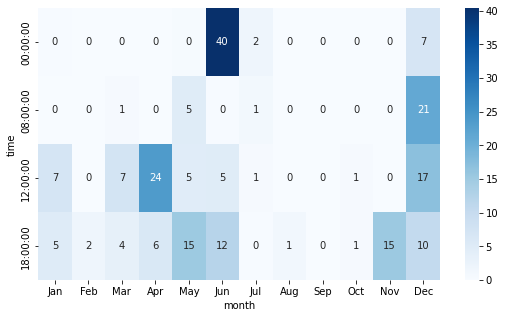

In [205]:
rain_mon_time = raindf1[['total', 'date', 'time']]
rain_mon_time['month'] = rain_mon_time['date'].apply(lambda x: x.strftime('%b'))
rain_pv = rain_mon_time.pivot_table(index='time', columns='month', values='total', aggfunc='sum')
rain_pv = rain_pv[["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]]

plt.figure(figsize=(9,5))
sns.heatmap(rain_pv, annot=True, fmt='.0f', cmap='Blues')

In [257]:
raindf2 = raindf1.iloc[:, :-3]
raindf2 = raindf2.T
raindf2.columns = raindf2.iloc[0]
raindf2 = raindf2[1:]

In [258]:
raindf2['total'] = raindf2.sum(axis=1)
raindf2.head()

datetime,2019-01-08T08:00:00,2019-01-08T12:00:00,2019-01-08T18:00:00,2019-01-08T00:00:00,2019-01-09T08:00:00,2019-01-09T12:00:00,2019-01-09T18:00:00,2019-01-09T00:00:00,2019-01-10T08:00:00,2019-01-10T12:00:00,2019-01-10T18:00:00,2019-01-10T00:00:00,2019-01-11T08:00:00,2019-01-11T12:00:00,2019-01-11T18:00:00,2019-01-11T00:00:00,2019-01-12T08:00:00,2019-01-12T12:00:00,2019-01-12T18:00:00,2019-01-12T00:00:00,2019-01-13T08:00:00,2019-01-13T12:00:00,2019-01-13T18:00:00,2019-01-13T00:00:00,2019-01-14T08:00:00,2019-01-14T12:00:00,2019-01-14T18:00:00,2019-01-14T00:00:00,2019-02-08T08:00:00,2019-02-08T12:00:00,2019-02-08T18:00:00,2019-02-08T00:00:00,2019-02-09T08:00:00,2019-02-09T12:00:00,2019-02-09T18:00:00,2019-02-09T00:00:00,2019-02-10T08:00:00,2019-02-10T12:00:00,2019-02-10T18:00:00,2019-02-10T00:00:00,2019-02-11T08:00:00,2019-02-11T12:00:00,2019-02-11T18:00:00,2019-02-11T00:00:00,2019-02-12T08:00:00,2019-02-12T12:00:00,2019-02-12T18:00:00,2019-02-12T00:00:00,2019-02-13T08:00:00,2019-02-13T12:00:00,2019-02-13T18:00:00,2019-02-13T00:00:00,2019-02-14T08:00:00,2019-02-14T12:00:00,2019-02-14T18:00:00,2019-02-14T00:00:00,2019-03-08T08:00:00,2019-03-08T12:00:00,2019-03-08T18:00:00,2019-03-08T00:00:00,2019-03-09T08:00:00,2019-03-09T12:00:00,2019-03-09T18:00:00,2019-03-09T00:00:00,2019-03-10T08:00:00,2019-03-10T12:00:00,2019-03-10T18:00:00,2019-03-10T00:00:00,2019-03-11T08:00:00,2019-03-11T12:00:00,2019-03-11T18:00:00,2019-03-11T00:00:00,2019-03-12T08:00:00,2019-03-12T12:00:00,2019-03-12T18:00:00,2019-03-12T00:00:00,2019-03-13T08:00:00,2019-03-13T12:00:00,2019-03-13T18:00:00,2019-03-13T00:00:00,2019-03-14T08:00:00,2019-03-14T12:00:00,2019-03-14T18:00:00,2019-03-14T00:00:00,2019-04-08T08:00:00,2019-04-08T12:00:00,2019-04-08T18:00:00,2019-04-08T00:00:00,2019-04-09T08:00:00,2019-04-09T12:00:00,2019-04-09T18:00:00,2019-04-09T00:00:00,2019-04-10T08:00:00,2019-04-10T12:00:00,2019-04-10T18:00:00,2019-04-10T00:00:00,2019-04-11T08:00:00,2019-04-11T12:00:00,2019-04-11T18:00:00,2019-04-11T00:00:00,2019-04-12T08:00:00,2019-04-12T12:00:00,2019-04-12T18:00:00,2019-04-12T00:00:00,2019-04-13T08:00:00,2019-04-13T12:00:00,2019-04-13T18:00:00,2019-04-13T00:00:00,2019-04-14T08:00:00,2019-04-14T12:00:00,2019-04-14T18:00:00,2019-04-14T00:00:00,2019-05-08T08:00:00,2019-05-08T12:00:00,2019-05-08T18:00:00,2019-05-08T00:00:00,2019-05-09T08:00:00,2019-05-09T12:00:00,2019-05-09T18:00:00,2019-05-09T00:00:00,2019-05-10T08:00:00,2019-05-10T12:00:00,2019-05-10T18:00:00,2019-05-10T00:00:00,2019-05-11T08:00:00,2019-05-11T12:00:00,2019-05-11T18:00:00,2019-05-11T00:00:00,2019-05-12T08:00:00,2019-05-12T12:00:00,2019-05-12T18:00:00,2019-05-12T00:00:00,2019-05-13T08:00:00,2019-05-13T12:00:00,2019-05-13T18:00:00,2019-05-13T00:00:00,2019-05-14T08:00:00,2019-05-14T12:00:00,2019-05-14T18:00:00,2019-05-14T00:00:00,2019-06-08T08:00:00,2019-06-08T12:00:00,2019-06-08T18:00:00,2019-06-08T00:00:00,2019-06-09T08:00:00,2019-06-09T12:00:00,2019-06-09T18:00:00,2019-06-09T00:00:00,2019-06-10T08:00:00,2019-06-10T12:00:00,2019-06-10T18:00:00,2019-06-10T00:00:00,2019-06-11T08:00:00,2019-06-11T12:00:00,2019-06-11T18:00:00,2019-06-11T00:00:00,2019-06-12T08:00:00,2019-06-12T12:00:00,2019-06-12T18:00:00,2019-06-12T00:00:00,2019-06-13T08:00:00,2019-06-13T12:00:00,2019-06-13T18:00:00,2019-06-13T00:00:00,2019-06-14T08:00:00,2019-06-14T12:00:00,2019-06-14T18:00:00,2019-06-14T00:00:00,2019-07-08T08:00:00,2019-07-08T12:00:00,2019-07-08T18:00:00,2019-07-08T00:00:00,2019-07-09T08:00:00,2019-07-09T12:00:00,2019-07-09T18:00:00,2019-07-09T00:00:00,2019-07-10T08:00:00,2019-07-10T12:00:00,2019-07-10T18:00:00,2019-07-10T00:00:00,2019-07-11T08:00:00,2019-07-11T12:00:00,2019-07-11T18:00:00,2019-07-11T00:00:00,2019-07-12T08:00:00,2019-07-12T12:00:00,2019-07-12T18:00:00,2019-07-12T00:00:00,2019-07-13T08:00:00,2019-07-13T12:00:00,2019-07-13T18:00:00,2019-07-13T00:00:00,2019-07-14T08:00:00,2019-07-14T12:00:00,2019-07-14T18:00:00,2019-07-14T00:00:00,2019-08-08T08:00:00,2019-08-08T12:00:00,2019-08-08T18:00:00,2019-08-08T

In [266]:
rain2019 = pd.DataFrame(raindf2['total']).rename(columns={'total': 'Rain (mm)'})
rain2019['latitude'] = ''
rain2019['longitude'] = ''
rain2019.head()

,Rain (mm),latitude,longitude
S105,13.0,,
S77,0.6,,
S109,1.6,,
S117,2.0,,
S55,1.4,,


In [268]:
for k, v in rain_loc.items():
    rain2019.loc[k, 'latitude'] = v['location']['latitude']
    rain2019.loc[k, 'longitude'] = v['location']['longitude']

In [269]:
rain2019

,Rain (mm),latitude,longitude
S105,13.000,1.45817,103.79525
S77,0.600,1.2937,103.8125
S109,1.600,1.3764,103.8492
S117,2.000,1.256,103.679
S55,1.400,1.3837,103.886
S64,8.000,1.3824,103.7603
S90,1.200,1.3191,103.8191
S61,1.800,1.323,103.9217
S114,2.200,1.38,103.73
S11,7.200,1.3746,103.6938


In [102]:
sg = geopandas.read_file('singapore_map/subzone-census2010-shp/Subzone_Census2010.shp')
sg1 = sg.to_crs("EPSG:4326")

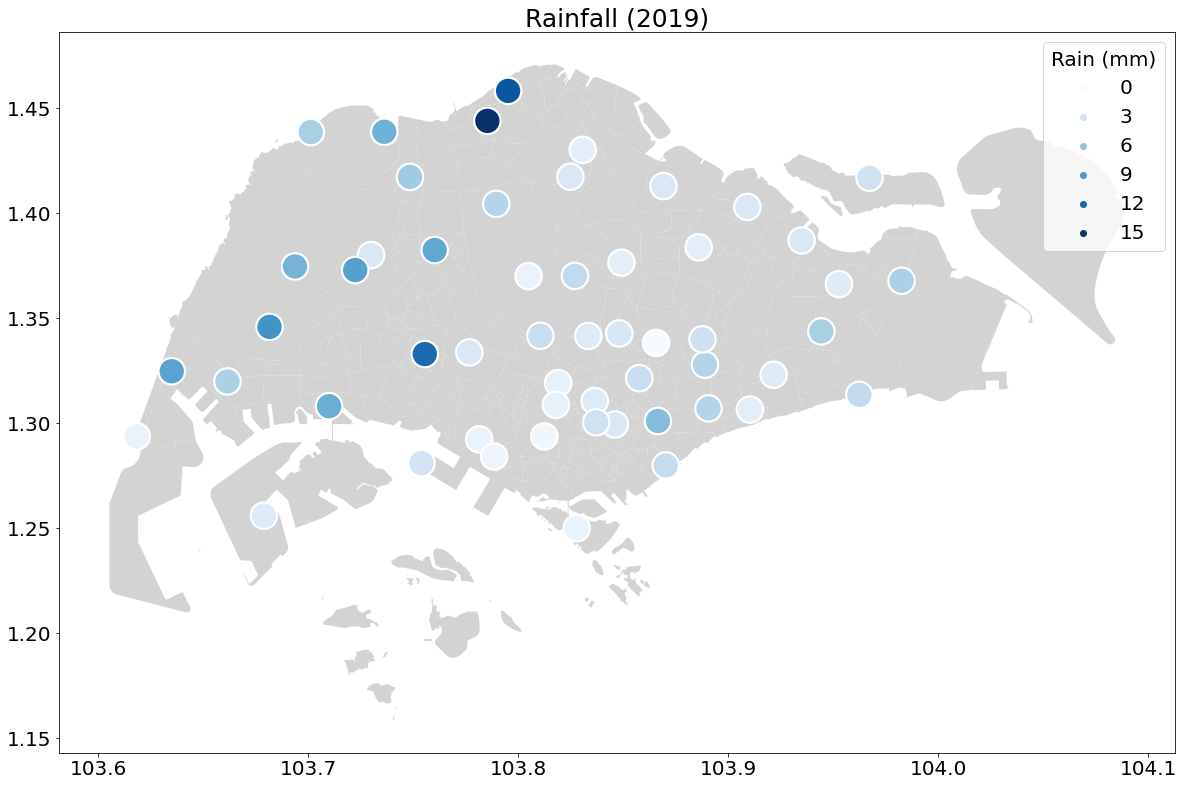

In [306]:
ax = sg1.plot(figsize=(20,20), color='lightgray')
sns.scatterplot(data=rain2019, x="longitude", y="latitude", hue="Rain (mm)", ax=ax, s=700, palette='Blues')
plt.legend(title='Rain (mm)', fontsize=20, title_fontsize=20)
plt.title('Rainfall (2019)', fontsize=25)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [4]:
rain_loc

{'S105': {'name': 'Admiralty Road West',
  'location': {'latitude': 1.45817, 'longitude': 103.79525}},
 'S77': {'name': 'Alexandra Road',
  'location': {'latitude': 1.2937, 'longitude': 103.8125}},
 'S109': {'name': 'Ang Mo Kio Avenue 5',
  'location': {'latitude': 1.3764, 'longitude': 103.8492}},
 'S117': {'name': 'Banyan Road',
  'location': {'latitude': 1.256, 'longitude': 103.679}},
 'S55': {'name': 'Buangkok Green',
  'location': {'latitude': 1.3837, 'longitude': 103.886}},
 'S64': {'name': 'Bukit Panjang Road',
  'location': {'latitude': 1.3824, 'longitude': 103.7603}},
 'S90': {'name': 'Bukit Timah Road',
  'location': {'latitude': 1.3191, 'longitude': 103.8191}},
 'S61': {'name': 'Chai Chee Street',
  'location': {'latitude': 1.323, 'longitude': 103.9217}},
 'S114': {'name': 'Choa Chu Kang Avenue 4',
  'location': {'latitude': 1.38, 'longitude': 103.73}},
 'S11': {'name': 'Choa Chu Kang Road',
  'location': {'latitude': 1.3746, 'longitude': 103.6938}},
 'S50': {'name': 'Clement

### Get Taxi Data

In [310]:
def get_taxi_data(query:str):
    '''Returns the coordinates of all taxis via the LTA API endpoint for a given datetime string
    '''
    URL = "https://api.data.gov.sg/v1/transport/taxi-availability"
    params={'date_time':query}
    r=requests.get(URL,params=params)
    return r.json()

In [311]:
# query data from API
taxi = {}
for query in query_list:
    taxi[query] = get_taxi_data(query)

In [5]:
# save taxi data in json file
# with open("taxi_data_2019.json", "w") as outfile:
#     json.dump(taxi, outfile)
    
# to open:
with open('taxi_data_2019.json', 'r') as openfile:
    taxi = json.load(openfile)

In [6]:
taxi['2019-01-08T08:00:00']

{'type': 'FeatureCollection',
 'crs': {'type': 'link',
  'properties': {'href': 'http://spatialreference.org/ref/epsg/4326/ogcwkt/',
   'type': 'ogcwkt'}},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'MultiPoint',
    'coordinates': [[103.62316, 1.29928],
     [103.62388, 1.28696],
     [103.6245, 1.303],
     [103.62492, 1.28891],
     [103.62796, 1.31237],
     [103.62841, 1.31361],
     [103.62931, 1.30094],
     [103.6294, 1.31588],
     [103.6296, 1.31964],
     [103.6302, 1.30143],
     [103.63025, 1.31464],
     [103.6319, 1.31125],
     [103.63275, 1.32457],
     [103.63282, 1.31025],
     [103.63322, 1.30124],
     [103.63476, 1.33423],
     [103.63486, 1.30252],
     [103.6358, 1.31658],
     [103.63607, 1.32449],
     [103.63636, 1.28385],
     [103.63747, 1.30741],
     [103.63752, 1.33205],
     [103.6376, 1.30048],
     [103.6376, 1.34767],
     [103.63761, 1.30023],
     [103.63761, 1.30032],
     [103.63762, 1.30038],
     [103.637959833333, 1.3298107],
  

In [7]:
len(taxi)

336

In [8]:
count = 0
for k in taxi.keys():
    for x in taxi[k]['features'][0]['geometry']['coordinates']:
        count += 1
count

1125079

In [22]:
station_array = np.array([[rain_loc[i]['location']['longitude'],rain_loc[i]['location']['latitude']] for i in rain_loc.keys()])

In [59]:
def assign_taxis(taxi_array:type(np.array),station_array:type(np.array)):
    cartesian_prod = itertools.product(taxi_array,station_array) # Cartesian product for taxi and weather station coordinates
    diff = np.array([i[0]-i[1] for i in cartesian_prod]) 
    distance = np.linalg.norm(diff,axis=1)
    distance_matrix = distance.reshape((len(taxi_array),len(station_array),-1)) # Reshape back into distances since the cartesian product only has one dimension
    return [np.argmin(distance_matrix[i]) for i in range(len(taxi_array))]

In [89]:
taxidf = pd.DataFrame(list(rain_loc.keys()), columns=['station'])

for k, v in taxi.items():
    taxi_coordinates = v['features'][0]['geometry']['coordinates']
    if len(taxi_coordinates) >0:
        taxi_array = np.array([c for c in taxi_coordinates])
        assignment = assign_taxis(taxi_array,station_array)
        assignment_series = pd.Series(assignment)
        assignment_counts = assignment_series.value_counts().sort_index()
        taxidf = taxidf.join(pd.DataFrame(assignment_counts, columns=[k])).fillna(0)

In [91]:
taxidf1 = taxidf.set_index('station')
taxidf1['mean'] = taxidf1.mean(axis=1)
taxidf1

,2019-01-08T08:00:00,2019-01-08T12:00:00,2019-01-08T18:00:00,2019-01-08T00:00:00,2019-01-09T08:00:00,2019-01-09T12:00:00,2019-01-09T18:00:00,2019-01-09T00:00:00,2019-01-10T08:00:00,2019-01-10T12:00:00,2019-01-10T18:00:00,2019-01-10T00:00:00,2019-01-11T08:00:00,2019-01-11T12:00:00,2019-01-11T18:00:00,2019-01-11T00:00:00,2019-01-12T08:00:00,2019-01-12T12:00:00,2019-01-12T18:00:00,2019-01-12T00:00:00,2019-01-13T08:00:00,2019-01-13T12:00:00,2019-01-13T18:00:00,2019-01-13T00:00:00,2019-01-14T08:00:00,2019-01-14T12:00:00,2019-01-14T18:00:00,2019-01-14T00:00:00,2019-02-08T08:00:00,2019-02-08T12:00:00,2019-02-08T18:00:00,2019-02-08T00:00:00,2019-02-09T08:00:00,2019-02-09T12:00:00,2019-02-09T18:00:00,2019-02-09T00:00:00,2019-02-10T08:00:00,2019-02-10T12:00:00,2019-02-10T18:00:00,2019-02-10T00:00:00,2019-02-11T08:00:00,2019-02-11T12:00:00,2019-02-11T18:00:00,2019-02-11T00:00:00,2019-02-12T08:00:00,2019-02-12T12:00:00,2019-02-12T18:00:00,2019-02-12T00:00:00,2019-02-13T08:00:00,2019-02-13T12:00:00,2019-02-13T18:00:00,2019-02-13T00:00:00,2019-02-14T08:00:00,2019-02-14T12:00:00,2019-02-14T18:00:00,2019-02-14T00:00:00,2019-03-08T08:00:00,2019-03-08T12:00:00,2019-03-08T18:00:00,2019-03-08T00:00:00,2019-03-09T08:00:00,2019-03-09T12:00:00,2019-03-09T18:00:00,2019-03-09T00:00:00,2019-03-10T08:00:00,2019-03-10T12:00:00,2019-03-10T18:00:00,2019-03-10T00:00:00,2019-03-11T08:00:00,2019-03-11T12:00:00,2019-03-11T18:00:00,2019-03-11T00:00:00,2019-03-12T08:00:00,2019-03-12T12:00:00,2019-03-12T18:00:00,2019-03-12T00:00:00,2019-03-13T08:00:00,2019-03-13T12:00:00,2019-03-13T18:00:00,2019-03-13T00:00:00,2019-03-14T08:00:00,2019-03-14T12:00:00,2019-03-14T18:00:00,2019-03-14T00:00:00,2019-04-08T08:00:00,2019-04-08T12:00:00,2019-04-08T18:00:00,2019-04-08T00:00:00,2019-04-09T08:00:00,2019-04-09T12:00:00,2019-04-09T18:00:00,2019-04-09T00:00:00,2019-04-10T08:00:00,2019-04-10T12:00:00,2019-04-10T18:00:00,2019-04-10T00:00:00,2019-04-11T08:00:00,2019-04-11T12:00:00,2019-04-11T18:00:00,2019-04-11T00:00:00,2019-04-12T08:00:00,2019-04-12T12:00:00,2019-04-12T18:00:00,2019-04-12T00:00:00,2019-04-13T08:00:00,2019-04-13T12:00:00,2019-04-13T18:00:00,2019-04-13T00:00:00,2019-04-14T08:00:00,2019-04-14T12:00:00,2019-04-14T18:00:00,2019-04-14T00:00:00,2019-05-08T08:00:00,2019-05-08T12:00:00,2019-05-08T18:00:00,2019-05-08T00:00:00,2019-05-09T08:00:00,2019-05-09T12:00:00,2019-05-09T18:00:00,2019-05-09T00:00:00,2019-05-10T08:00:00,2019-05-10T12:00:00,2019-05-10T18:00:00,2019-05-10T00:00:00,2019-05-11T08:00:00,2019-05-11T12:00:00,2019-05-11T18:00:00,2019-05-11T00:00:00,2019-05-12T08:00:00,2019-05-12T12:00:00,2019-05-12T18:00:00,2019-05-12T00:00:00,2019-05-13T08:00:00,2019-05-13T12:00:00,2019-05-13T18:00:00,2019-05-13T00:00:00,2019-05-14T08:00:00,2019-05-14T12:00:00,2019-05-14T18:00:00,2019-05-14T00:00:00,2019-06-08T08:00:00,2019-06-08T12:00:00,2019-06-08T18:00:00,2019-06-08T00:00:00,2019-06-09T08:00:00,2019-06-09T12:00:00,2019-06-09T18:00:00,2019-06-09T00:00:00,2019-06-10T08:00:00,2019-06-10T12:00:00,2019-06-10T18:00:00,2019-06-10T00:00:00,2019-06-11T08:00:00,2019-06-11T12:00:00,2019-06-11T18:00:00,2019-06-11T00:00:00,2019-06-12T08:00:00,2019-06-12T12:00:00,2019-06-12T18:00:00,2019-06-12T00:00:00,2019-06-13T08:00:00,2019-06-13T12:00:00,2019-06-13T18:00:00,2019-06-13T00:00:00,2019-06-14T08:00:00,2019-06-14T12:00:00,2019-06-14T18:00:00,2019-06-14T00:00:00,2019-07-08T08:00:00,2019-07-08T12:00:00,2019-07-08T18:00:00,2019-07-08T00:00:00,2019-07-09T08:00:00,2019-07-09T12:00:00,2019-07-09T18:00:00,2019-07-09T00:00:00,2019-07-10T08:00:00,2019-07-10T12:00:00,2019-07-10T18:00:00,2019-07-10T00:00:00,2019-07-11T08:00:00,2019-07-11T12:00:00,2019-07-11T18:00:00,2019-07-11T00:00:00,2019-07-12T08:00:00,2019-07-12T12:00:00,2019-07-12T18:00:00,2019-07-12T00:00:00,2019-07-13T08:00:00,2019-07-13T12:00:00,2019-07-13T18:00:00,2019-07-13T00:00:00,2019-07-14T08:00:00,2019-07-14T12:00:00,2019-07-14T18:00:00,2019-07-14T00:00:00,2019-08-08T08:00:00,2019-08-08T12:00:00,2019-08-08T18:00:00,2019-08-08T00:00:00

In [93]:
taxidf2 = taxidf1[['mean']]
taxidf2.head()

,mean
station,
S105,35.298193
S77,112.759036
S109,159.734940
S117,1.617470
S55,186.144578


In [101]:
station_loc = pd.DataFrame(station_array, columns=['longitude', 'latitude'])
taxidf3 = pd.concat([taxidf2.reset_index(), station_loc], axis=1, join="outer")
taxidf3.head()

,station,mean,longitude,latitude
0,S105,35.298193,103.79525,1.45817
1,S77,112.759036,103.81250,1.29370
2,S109,159.734940,103.84920,1.37640
3,S117,1.617470,103.67900,1.25600
4,S55,186.144578,103.88600,1.38370


In [103]:
sg = geopandas.read_file('singapore_map/subzone-census2010-shp/Subzone_Census2010.shp')
sg1 = sg.to_crs("EPSG:4326")

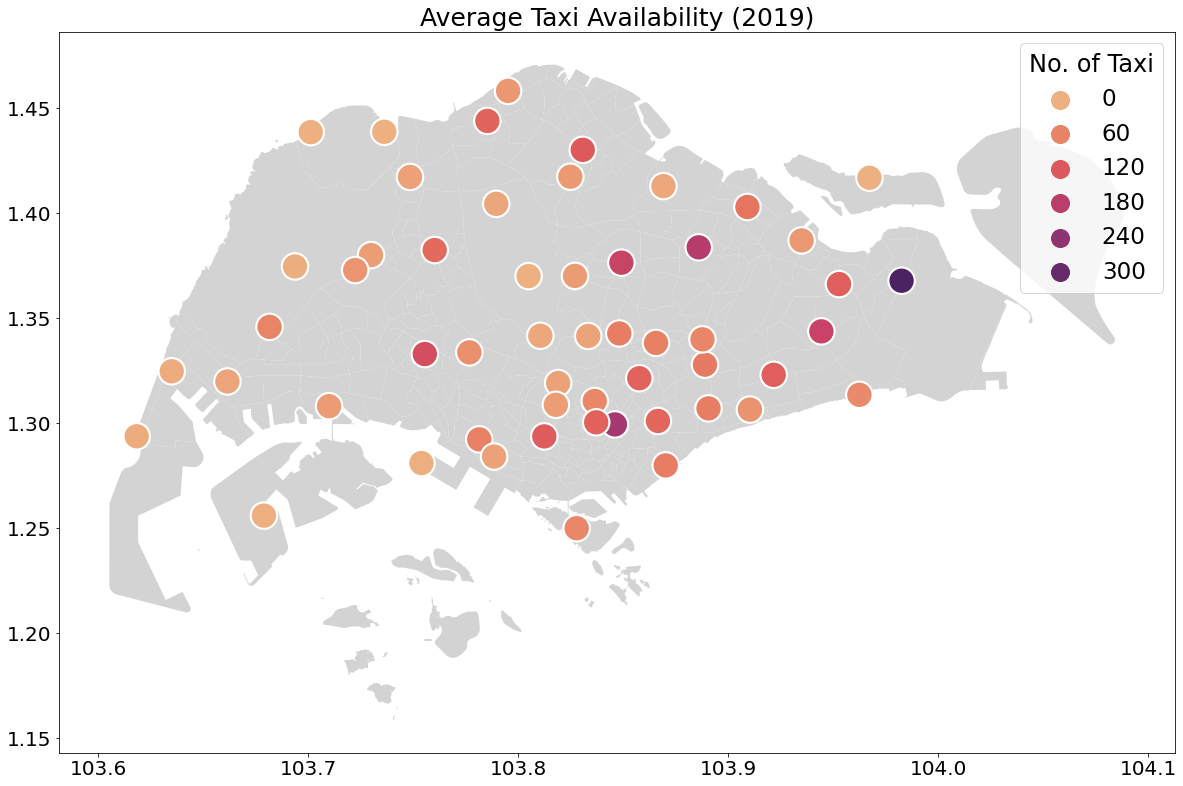

In [111]:
ax = sg1.plot(figsize=(20,20), color='lightgray')
sns.scatterplot(data=taxidf3, x="longitude", y="latitude", hue="mean", ax=ax, s=700, palette='flare')
plt.legend(title='No. of Taxi', fontsize=23, title_fontsize=24, markerscale=3)
plt.title('Average Taxi Availability (2019)', fontsize=25)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()